# Clase 05b: Análisis vectorial y Geoprocesos

Luego de haber probado con distintos filtros espaciales de nuestras casificaciones y haberlas vectorizado, pasaremos a aprender algunos geoprocesos que nos permitirán obtener información nueva.

Abordaremos aquí un caso de aplicación: A partir de nuestras clasificaciones vectorizadas, haremos operaciones para conocer el área construida por radio censal. La idea será llegar a algo parecido a lo siguiente:

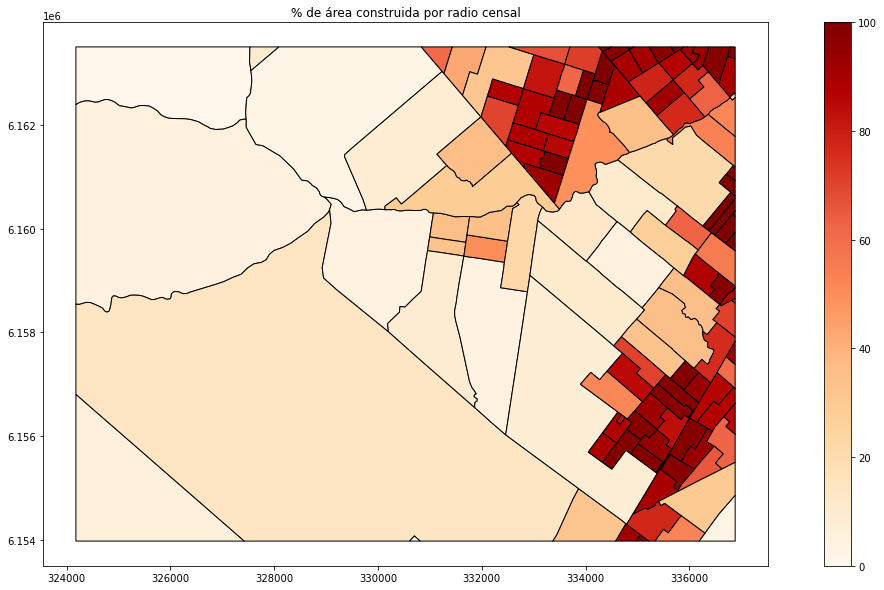

Contamos con la base cartográfica del Censo Nacional de Población y Vivienda de 2010, que incluye tanto polígonos de fracciones como radios censales para cada provincia del país, y aprovecharemos la capa de clasificación poligonizada que trabajamo en la Notebook anterior.

## 1. Conocer la cantidad de área construida por radio censal

### 1.1. Intersección

Ahora que tenemos la clasificación en formato vectorial, estamos habilitados a realizar otras operaciones. Como vimos en la Clase 04, al leer un vector como GeoDataFrame podemos, entre otras cosas, calcular el área de cada elemento. El problema es que a nosotros nos interesa saber el área construida por Radio Censal, con lo cual estamos ante un problema de agregación espacial: Tenemos que "pasarle" de alguna manera la información del radio al que pertenece a cada uno de los polígonos de la clasificación. 

En un ambiente SIG, esto suele resolverse con lo que se conoce como **geoprocesos**, que son operaciones donde se genera nueva información a partir de la relación espacial o geométrica entre varios vectores. Uno de los más usados es la **intersección** , donde se combinan las geometrías de dos capas vectoriales dando lugar a una nueva:

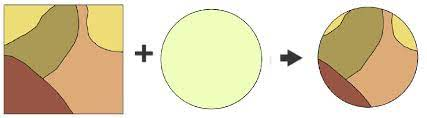

La particularidad que tiene este geoproceso es que además de combinarse las geometrías, también se combinan los atributos o columnas. Veamos como se hace con GeoPandas:

```python
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
import funciones as fn

clasif_vector = gpd.read_file('../data/proc/clasif_mode.shp')
radios = gpd.read_file('../data/raw_data/vector/radios_BA.shp')

#Consultamos el SRC de las capas:
print(radios.crs, clasif_vector.crs)

#Reproyectamos los radios al SRC de la clasificación:
radios = radios.to_crs(32721)
```

In [1]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
from matplotlib import pyplot as plt
import funciones as fn

clasif_vector = gpd.read_file('./proc/clasif_mode.shp')
radios = gpd.read_file('./raw_data/vector/radios_BA.shp')

#Consultamos el SRC de las capas:
print(radios.crs, clasif_vector.crs)

#Reproyectamos los radios al SRC de la clasificación:
radios = radios.to_crs(32721)

EPSG:22183 EPSG:32721


Como son vectores con distinta extensión espacial, debemos definir los límites del ploteo: Nos interesa tomar las coordenadas de nuestra clasificación solamente:

```python
minx, miny, maxx, maxy = clasif_vector.total_bounds

#Los visualizamos en conjunto:

ax = clasif_vector.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
radios.boundary.plot(ax=ax, edgecolor='black', zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()
```

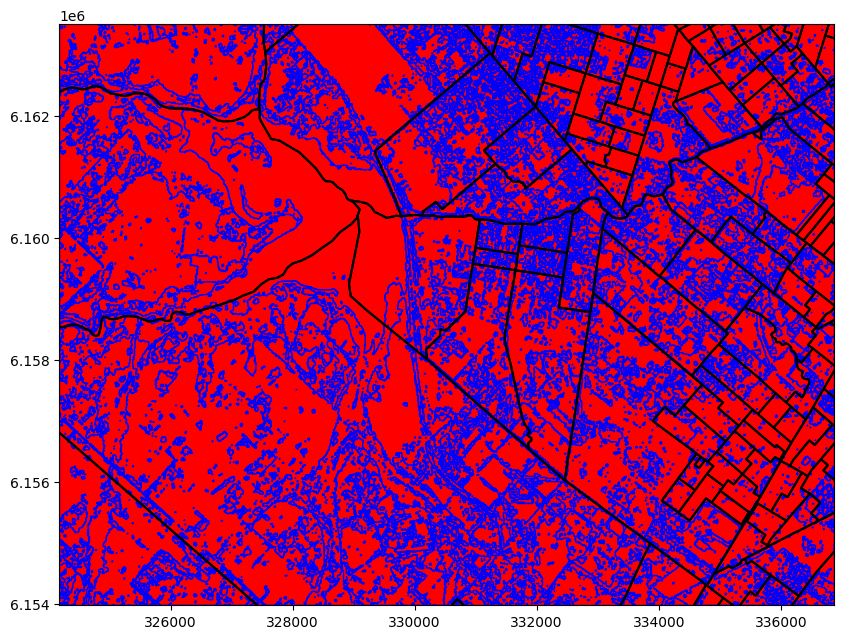

In [2]:
minx, miny, maxx, maxy = clasif_vector.total_bounds

#Los visualizamos en conjunto:

ax = clasif_vector.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
radios.boundary.plot(ax=ax, edgecolor='black', zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

La capa de radios censales ocupa toda la extensión de la Provincia de Buenos Aires. Sin embargo, luego de hacer la intersección la salida quedará reducida a la extensión de la clasificación.

Geopandas permite realizar sus geoprocesos por medio del método **Overlay**, que se refiere a superposición. Además de la intersección, se puede unir geometrías, obtener la diferencia entre las mismas, o su diferencia simétrica. Se puede consultar con más detalle en la [documentación](https://geopandas.org/docs/user_guide/set_operations.html) de Geopandas.

```python
#Hacemos la intersección

interseccion = gpd.overlay(clasif_vector,radios, how ='intersection')
interseccion.head(5)
```

In [3]:
interseccion = gpd.overlay(clasif_vector,radios, how ='intersection')
interseccion.head(5)

value  toponimo_i       link  varon  mujer  totalpobl  hogares  viviendasp  \
0    2.0      334646  063640413  507.0  361.0      868.0    200.0       240.0   
1    2.0      334646  063640413  507.0  361.0      868.0    200.0       240.0   
2    3.0      334646  063640413  507.0  361.0      868.0    200.0       240.0   
3    2.0      334646  063640413  507.0  361.0      868.0    200.0       240.0   
4    1.0      334646  063640413  507.0  361.0      868.0    200.0       240.0   

   viv_part_h                                           geometry  
0       189.0  POLYGON ((324940 6163500, 324940 6163490, 3249...  
1       189.0  POLYGON ((326370 6163500, 326370 6163490, 3263...  
2       189.0  POLYGON ((327410 6163500, 327410 6163490, 3273...  
3       189.0  POLYGON ((324860 6163500, 324860 6163480, 3248...  
4       189.0  POLYGON ((325420 6163500, 325420 6163480, 3254...

Ploteamos esta nueva capa coloreando los elementos por el código original del radio, para ver qué aspecto tiene:

```python
interseccion.plot(column = 'link',figsize = (10,10), edgecolor = 'black')
plt.show()
```

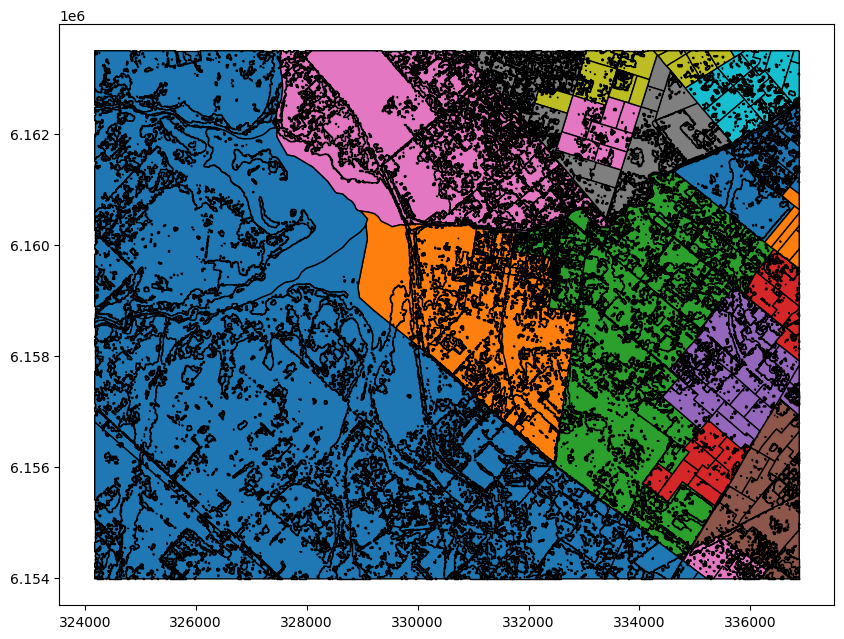

In [4]:
interseccion.plot(column = 'link',figsize = (10,10), edgecolor = 'black')
plt.show()

Como se puede ver, ahora hemos combinado las geometrías de ambas capas, y en la tabla vemos tanto la columna DN (heredada de la clasificación), como los campos que venían con la tabla de radios. Podemos ahora calcular el área de aquellos polígonos pertenecientes a la clase 4 (Construcciones / Urbano). Recordemos las clases de nuestra clasificación:

- Agua: Píxeles con valor 0
- Bosque: Píxeles con valor 1
- Humedal: Píxeles con valor 2
- Rural: Píxeles con valor 3
- Urbano: Píxeles con valor 4


```python
interseccion.loc[interseccion.DN == 4, 'area_construido_m2'] = interseccion.loc[interseccion.DN == 4].area
```

In [5]:
interseccion.columns

Index(['value', 'toponimo_i', 'link', 'varon', 'mujer', 'totalpobl', 'hogares',
       'viviendasp', 'viv_part_h', 'geometry'],
      dtype='object')

In [6]:
interseccion.loc[interseccion['value'] == 4, 'area_construido_m2'] = interseccion.loc[interseccion['value'] == 4].area

Si nos fijamos de nuevo en la tabla, solo se ha calculado el área para la clase 4:

```python
#Nos traemos los primeros 5, luego de ordenar de manera descendente por area_construido_m2
interseccion.sort_values('area_construido_m2', ascending=False).head(5)
```

In [7]:
interseccion.sort_values('area_construido_m2', ascending=False).head(5)

value  toponimo_i       link  varon  mujer  totalpobl  hogares  \
12140    4.0      286198  065250301   71.0   44.0      115.0     35.0   
11951    4.0      286198  065250301   71.0   44.0      115.0     35.0   
4690     4.0      309570  065602010  718.0  704.0     1422.0    325.0   
4202     4.0      334648  063640414   74.0   68.0      142.0     47.0   
11471    4.0      286198  065250301   71.0   44.0      115.0     35.0   

       viviendasp  viv_part_h  \
12140        43.0        33.0   
11951        43.0        33.0   
4690        330.0       313.0   
4202         51.0        47.0   
11471        43.0        33.0   

                                                geometry  area_construido_m2  
12140  POLYGON ((329010 6156570, 329010 6156560, 3290...        1.294700e+06  
11951  POLYGON ((328070 6155780, 328070 6155760, 3280...        6.986000e+05  
4690   MULTIPOLYGON (((334320 6162070, 334328.663 616...        5.642061e+05  
4202   POLYGON ((324910 6161370, 324910 6161360, 3249...        5.290000e+05  
11471  POLYGON ((329660 6155810, 329660 6155800, 3297...        4.138000e+05

Sin embargo no tenemos aún agregados los datos por radio censal, tenemos nuestros polígonos partidos por los límites de las dos capas originales. 

Lo que podemos hacer ahora es una operación de agregación espacial que se conoce como **Disolver**. Con el Disolver lo que hacemos es agrupar las geometrías en base a una o más columnas, y se genera una nueva capa. Sobre el resto de los datos se puede aplicar algún criterio de agregación o sumarización: Por ejemplo, obtener la media, la suma, la moda, etc:

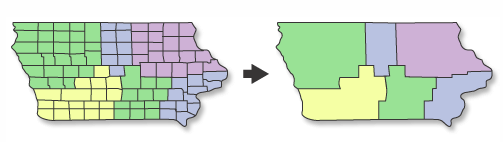

Con GeoPandas hacemos esto con el método **dissolve** (consulta más información sobre este comando [aquí](https://geopandas.org/docs/user_guide/aggregation_with_dissolve.html)):

```python
dissolve = interseccion.dissolve(by = 'link', aggfunc = 'sum', as_index = False)

dissolve.plot(column = 'link',figsize = (10,10), edgecolor = 'black',cmap = 'tab20c')
plt.show()

dissolve.head(5)
```

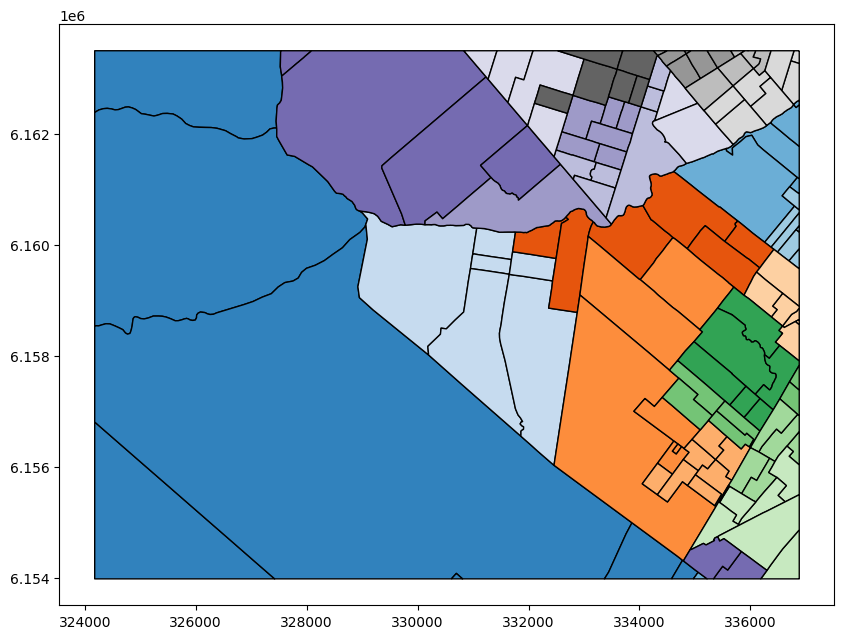

link                                           geometry   value  \
0  063640413  POLYGON ((324180 6162500, 324180 6162520, 3241...   472.0   
1  063640414  POLYGON ((324249.568 6158540.052, 324184.457 6...  1807.0   
2  065250202  POLYGON ((324380 6153980, 324330 6153980, 3243...   827.0   
3  065250301  POLYGON ((324744.551 6156315.639, 324690 61563...  7981.0   
4  065250302  POLYGON ((330609.507 6153980, 330691.113 61540...    15.0   

   toponimo_i     varon     mujer  totalpobl   hogares  viviendasp  \
0    82657562  125229.0   89167.0   214396.0   49400.0     59280.0   
1   251989944   55722.0   51204.0   106926.0   35391.0     38403.0   
2   109040676   24765.0   23622.0    48387.0   15240.0     19431.0   
3   914402610  226845.0  140580.0   367425.0  111825.0    137385.0   
4     2678072     808.0     472.0     1280.0     280.0       312.0   

   viv_part_h  area_construido_m2  
0     46683.0        9.000000e+03  
1     35391.0        7.481055e+05  
2     15240.0        2.836274e+05  
3    105435.0        4.747981e+06  
4       272.0        0.000000e+00

In [8]:
dissolve = interseccion.dissolve(by = 'link', aggfunc = 'sum', as_index = False)

dissolve.plot(column = 'link',figsize = (10,10), edgecolor = 'black',cmap = 'tab20c')
plt.show()

dissolve.head(5)

Ahora si! tenemos otra vez las geometrías de los radios originales, pero como usamos la función de agregación **sum** también sumarizamos la cantidad de metros cuadrados construidos, con lo cual para calcular el porcentaje solo debemos hacer un cálculo simple como lo aprendido en la Clase 4:

```python
# Opción para ver todas las columnas del dataset en el notebook
import pandas as pd
pd.set_option('display.max_columns', 50)

dissolve['porcen_construido'] = (dissolve['area_construido_m2']/dissolve.area)*100
dissolve.head(3)
```

In [9]:
import pandas as pd

pd.set_option('display.max_columns', 50)

dissolve['porcen_construido'] = (dissolve['area_construido_m2']/dissolve.area)*100
dissolve.head(3)

link                                           geometry   value  \
0  063640413  POLYGON ((324180 6162500, 324180 6162520, 3241...   472.0   
1  063640414  POLYGON ((324249.568 6158540.052, 324184.457 6...  1807.0   
2  065250202  POLYGON ((324380 6153980, 324330 6153980, 3243...   827.0   

   toponimo_i     varon    mujer  totalpobl  hogares  viviendasp  viv_part_h  \
0    82657562  125229.0  89167.0   214396.0  49400.0     59280.0     46683.0   
1   251989944   55722.0  51204.0   106926.0  35391.0     38403.0     35391.0   
2   109040676   24765.0  23622.0    48387.0  15240.0     19431.0     15240.0   

   area_construido_m2  porcen_construido  
0         9000.000000           0.209782  
1       748105.495210           5.426627  
2       283627.380699           6.182404

Ploteamos los radios en función del porcentaje calculado:

```python

dissolve.plot(column = 'porcen_construido',
                                         figsize = (20,10),
                                         edgecolor = 'black',
                                         cmap = 'OrRd',
                                        legend = True)
plt.title('% de área construida por radio censal')
```

Text(0.5, 1.0, '% de área construida por radio censal')

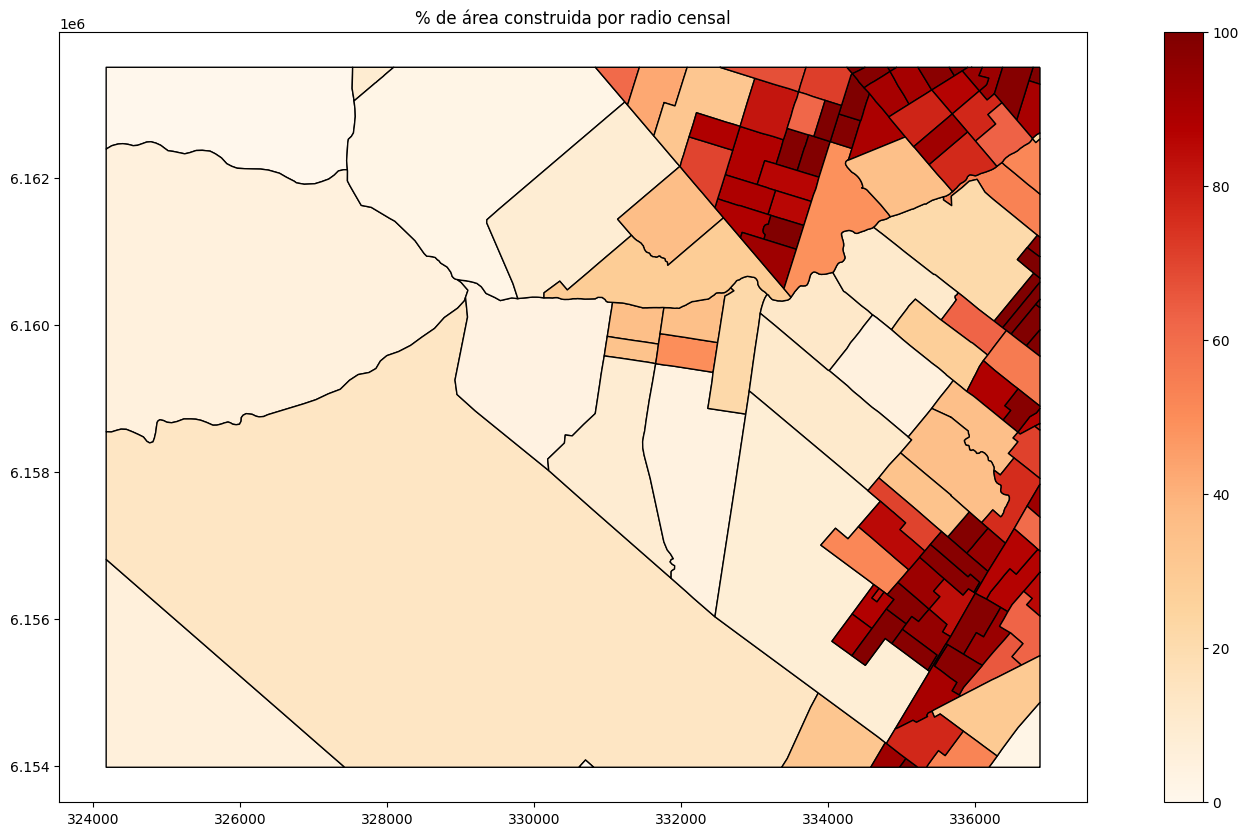

In [10]:
dissolve.plot(column = 'porcen_construido',
                                         figsize = (20,10),
                                         edgecolor = 'black',
                                         cmap = 'OrRd',
                                        legend = True)
plt.title('% de área construida por radio censal')

Para terminar de pulir un poco el resultado, deberíamos descartar todas las columnas que no se refieran al identificador del radio censal ('link') ni a la cantidad de m2 construidos ('area_construido_m2' y 'porcen_construido'), ya que sobre las mismas al hacer el dissolve se aplicó la función de suma cuando en realidad eran datos repetidos.

```python
dissolve = dissolve.drop(columns = ['DN', 'toponimo_i', 'varon', 'mujer', 'totalpobl',
       'hogares', 'viviendasp', 'viv_part_h'])
```

In [11]:
dissolve = dissolve.drop(columns = ['value', 'toponimo_i', 'varon', 'mujer', 'totalpobl',
       'hogares', 'viviendasp', 'viv_part_h'])

Guardamos nuestro resultado como archivo:

```python
dissolve.to_file('../data/proc/clase05_dissolve.gpkg')
```

In [12]:
dissolve.to_file('./proc/clase05_dissolve.gpkg')

### Ejercicio 1.1 (Opcional):

a) Realizar el procedimiento mostrado en el ejemplo de esta notebook, pero para calcular el porcentaje de cada radio censal que está cubierto por bosque, no por construcciones.

b) Programar una función que tomando una clasificación vectorial de entrada, un código de clase de dicha clasificación y una capa vectorial de polígonos, devuelva un Geodataframe donde esté calculado el porcentaje de área que esa clase ocupa en cada polígono del vector. 

In [15]:
#a
interseccion.head()
interseccion.loc[interseccion['value'] == 1, 'bosque_m2'] = interseccion.loc[interseccion['value'] == 1].area

In [16]:
interseccion.sort_values('bosque_m2', ascending=False).head(5)

value  toponimo_i       link  varon  mujer  totalpobl  hogares  \
1062     1.0      309548  065601917  348.0  309.0      657.0    165.0   
8995     1.0      309075  065392905  196.0  185.0      381.0     92.0   
1094     1.0      309548  065601917  348.0  309.0      657.0    165.0   
11183    1.0      286198  065250301   71.0   44.0      115.0     35.0   
4320     1.0      334648  063640414   74.0   68.0      142.0     47.0   

       viviendasp  viv_part_h  \
1062        213.0       159.0   
8995        102.0        86.0   
1094        213.0       159.0   
11183        43.0        33.0   
4320         51.0        47.0   

                                                geometry  area_construido_m2  \
1062   POLYGON ((329260 6163500, 329260 6163490, 3292...                 NaN   
8995   MULTIPOLYGON (((331790 6157300, 331790 6157290...                 NaN   
1094   POLYGON ((328290 6162130, 328290 6162110, 3283...                 NaN   
11183  POLYGON ((330320 6156170, 330320 6156160, 3303...                 NaN   
4320   POLYGON ((326400 6159730, 326400 6159720, 3264...                 NaN   

          bosque_m2  
1062   2.348123e+06  
8995   4.166343e+05  
1094   3.812000e+05  
11183  3.048000e+05  
4320   2.424000e+05

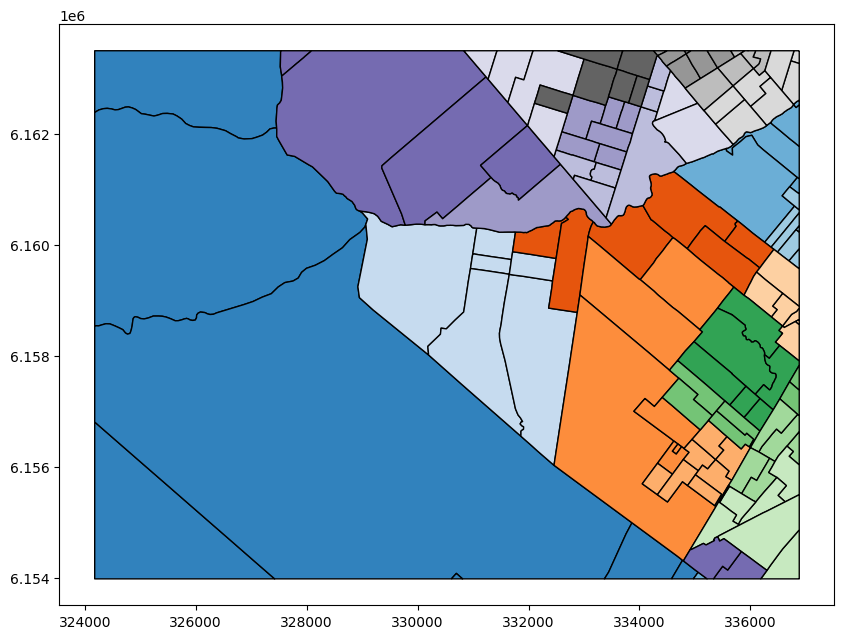

link                                           geometry   value  \
0  063640413  POLYGON ((324180 6162500, 324180 6162520, 3241...   472.0   
1  063640414  POLYGON ((324249.568 6158540.052, 324184.457 6...  1807.0   
2  065250202  POLYGON ((324380 6153980, 324330 6153980, 3243...   827.0   
3  065250301  POLYGON ((324744.551 6156315.639, 324690 61563...  7981.0   
4  065250302  POLYGON ((330609.507 6153980, 330691.113 61540...    15.0   

   toponimo_i     varon     mujer  totalpobl   hogares  viviendasp  \
0    82657562  125229.0   89167.0   214396.0   49400.0     59280.0   
1   251989944   55722.0   51204.0   106926.0   35391.0     38403.0   
2   109040676   24765.0   23622.0    48387.0   15240.0     19431.0   
3   914402610  226845.0  140580.0   367425.0  111825.0    137385.0   
4     2678072     808.0     472.0     1280.0     280.0       312.0   

   viv_part_h  area_construido_m2     bosque_m2  
0     46683.0        9.000000e+03  2.084810e+05  
1     35391.0        7.481055e+05  6.456380e+05  
2     15240.0        2.836274e+05  3.430130e+05  
3    105435.0        4.747981e+06  1.961735e+06  
4       272.0        0.000000e+00  3.571501e+03

In [17]:
dissolve2 = interseccion.dissolve(by = 'link', aggfunc = 'sum', as_index = False)

dissolve2.plot(column = 'link',figsize = (10,10), edgecolor = 'black',cmap = 'tab20c')
plt.show()

dissolve2.head(5)

In [19]:
import pandas as pd
pd.set_option('display.max_columns', 50)

dissolve2['porcen_bosque'] = (dissolve2['bosque_m2']/dissolve2.area)*100
dissolve2.head(3)

link                                           geometry   value  \
0  063640413  POLYGON ((324180 6162500, 324180 6162520, 3241...   472.0   
1  063640414  POLYGON ((324249.568 6158540.052, 324184.457 6...  1807.0   
2  065250202  POLYGON ((324380 6153980, 324330 6153980, 3243...   827.0   

   toponimo_i     varon    mujer  totalpobl  hogares  viviendasp  viv_part_h  \
0    82657562  125229.0  89167.0   214396.0  49400.0     59280.0     46683.0   
1   251989944   55722.0  51204.0   106926.0  35391.0     38403.0     35391.0   
2   109040676   24765.0  23622.0    48387.0  15240.0     19431.0     15240.0   

   area_construido_m2      bosque_m2  porcen_bosque  
0         9000.000000  208480.974605       4.859498  
1       748105.495210  645637.988428       4.683346  
2       283627.380699  343013.005859       7.476870

Text(0.5, 1.0, '% de bosque por radio censal')

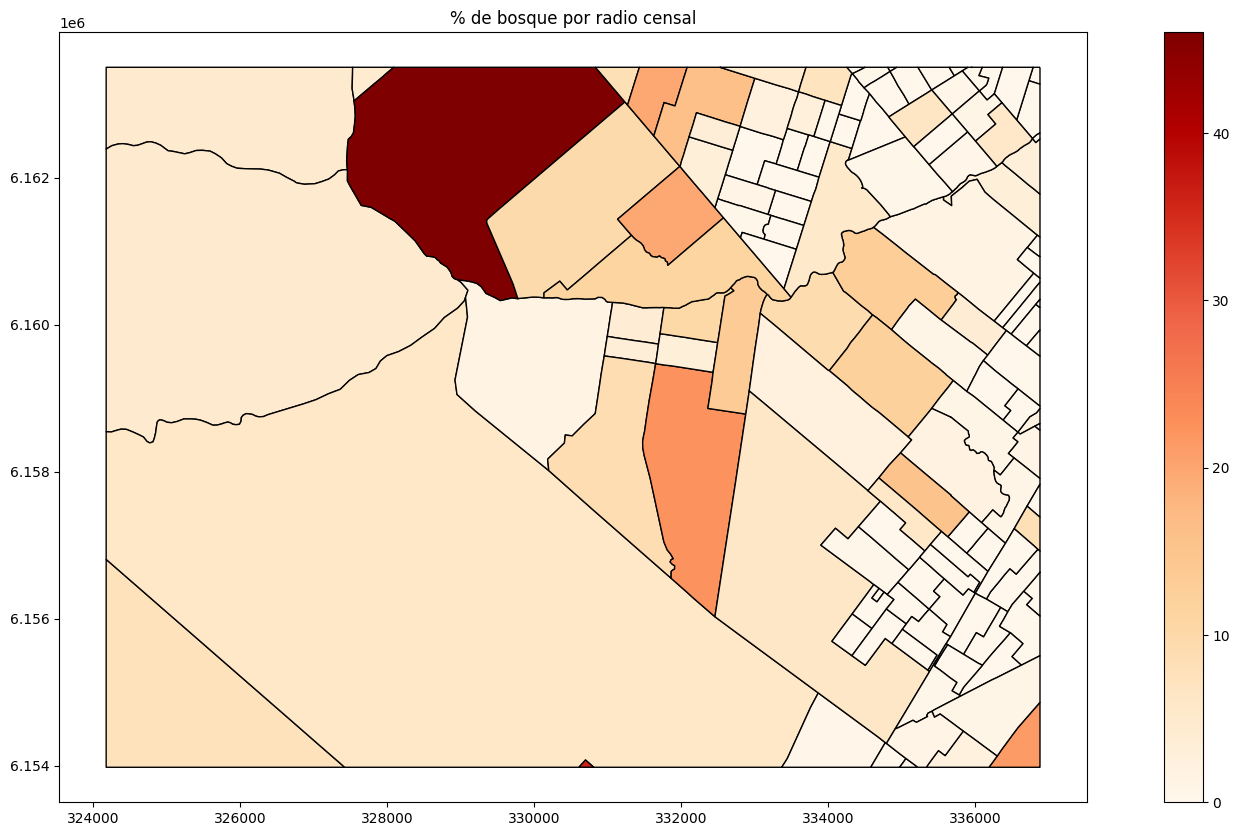

In [21]:
dissolve2.plot(column = 'porcen_bosque',
                                         figsize = (20,10),
                                         edgecolor = 'black',
                                         cmap = 'OrRd',
                                        legend = True)
plt.title('% de bosque por radio censal')

In [22]:
dissolve2 = dissolve2.drop(columns = ['value', 'toponimo_i', 'varon', 'mujer', 'totalpobl',
       'hogares', 'viviendasp', 'viv_part_h'])

dissolve2.to_file('./proc/clase05_dissolve2.gpkg')

In [24]:
#Punto 1b
import importlib
import funciones as fn  # o como hayas llamado tu archivo sin el .py
importlib.reload(fn)


clasif_vector = gpd.read_file('./proc/clasif_mode.shp')
radios = gpd.read_file('./raw_data/vector/radios_BA.shp')

radios = radios.to_crs(clasif_vector.crs)

resultado = fn.porcentaje_area_por_clase(clasif_vector, codigo_clase=4, poligonos=radios)

print(resultado[['link', 'pct_area_clase']].head())

resultado.to_file('./proc/radios_con_pct_construido.geojson', driver='GeoJSON')

        link  pct_area_clase
0  068821704             0.0
1  060141201             0.0
2  060210206             0.0
3  060070107             0.0
4  060210609             0.0


In [27]:
resultado["pct_area_clase"].value_counts()

pct_area_clase
0.000000     19454
35.836560        1
13.007705        1
70.193650        1
99.012820        1
             ...  
47.446514        1
94.579534        1
62.757894        1
11.196629        1
76.556844        1
Name: count, Length: 124, dtype: int64

### 1.2. Join o Unión Espacial

La unión espacial o _Spatial Join_ en inglés es otra de las operaciones de superposición más usadas en el análisis vectorial. Funciona de manera similar al Merge que aprendimos en la clase 04, en el sentido de que se unen atributos de dos tablas distintas, pero en este caso la unión se realiza en base a la localización en común.

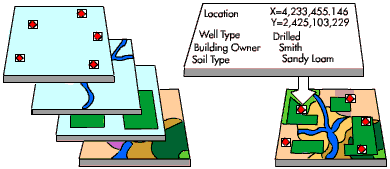

Se suele definir un criterio para "pasar" atributos de una capa a la otra: Por ejemplo si los elementos se intersectan entre sí, o si uno contiene al otro, o si el centro geométrico de un elemento se encuentra comprendido dentro del otro, etc. Geopandas en particular trabaja con distintos tipos de posibles relaciones o predicados geométricos. Se los puede consultar usando `GeoDataFrame.sindex.valid_query_predicates`:

```python
radios.sindex.valid_query_predicates
```



In [28]:
radios.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

Si quisiéramos por ejemplo pasarle a nuestra capa original de radios, los datos nuevos que calculamos con los m2 construidos, podríamos hacer un _merge_ a nivel de tablas como aprendimos en la Clase 4, o bien podríamos usar el Join espacial que estamos presentando ahora: 

```python
from geopandas.tools import sjoin

radios_sjoin = sjoin(dissolve,radios, how = 'inner', predicate = 'intersects')
```

In [29]:
from geopandas.tools import sjoin

radios_sjoin = sjoin(dissolve,radios, how = 'inner', predicate = 'intersects')

En el comando **sjoin** tenemos dos parámetros importantes para configurar, que son **how** y **predicate**. El primero nos indica cómo queremos hacer el join ('left', 'inner' o right), y funciona exactamente igual que en el **merge** de Pandas. El segundo se refiere a qué predicado geométrico usar: En este caso pusimos 'intersects' lo cual indica que el join se realizará cuando tengamos dos geometrías que se intersectan.

A primera vista, esto parece funcionar correctamente:

```python
radios_sjoin.head(3)
radios_sjoin.plot(edgecolor = 'black')
```

<Axes: >

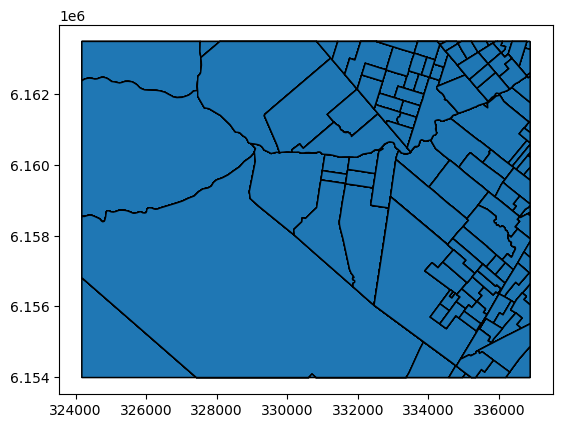

In [30]:
radios_sjoin.head(3)
radios_sjoin.plot(edgecolor = 'black')

Sin embargo, hay un problema. Si consultamos la cantidad de elementos de esta nueva capa, y la cantidad de elementos de la capa **dissolve** , estos no son iguales:

```python
print(len(dissolve))
print(len(radios_sjoin))
```

In [31]:
print(len(dissolve))
print(len(radios_sjoin))

124
776


El problema es por el predicado geométrico que estamos usando: al tratarse de una intersección, se generará un elemento nuevo por cada geometría coincida espacialmente con otra, incluso si solo comparten sus bordes. Llevemos la capa a QGIS para ver este problema más claramente:

```python
dissolve.to_file('../data/proc/dissolve.shp')
radios_sjoin.to_file('../data/proc/radios_sjoin.shp')
```

In [32]:
dissolve.to_file('./proc/dissolve.shp')
radios_sjoin.to_file('./proc/radios_sjoin.shp')

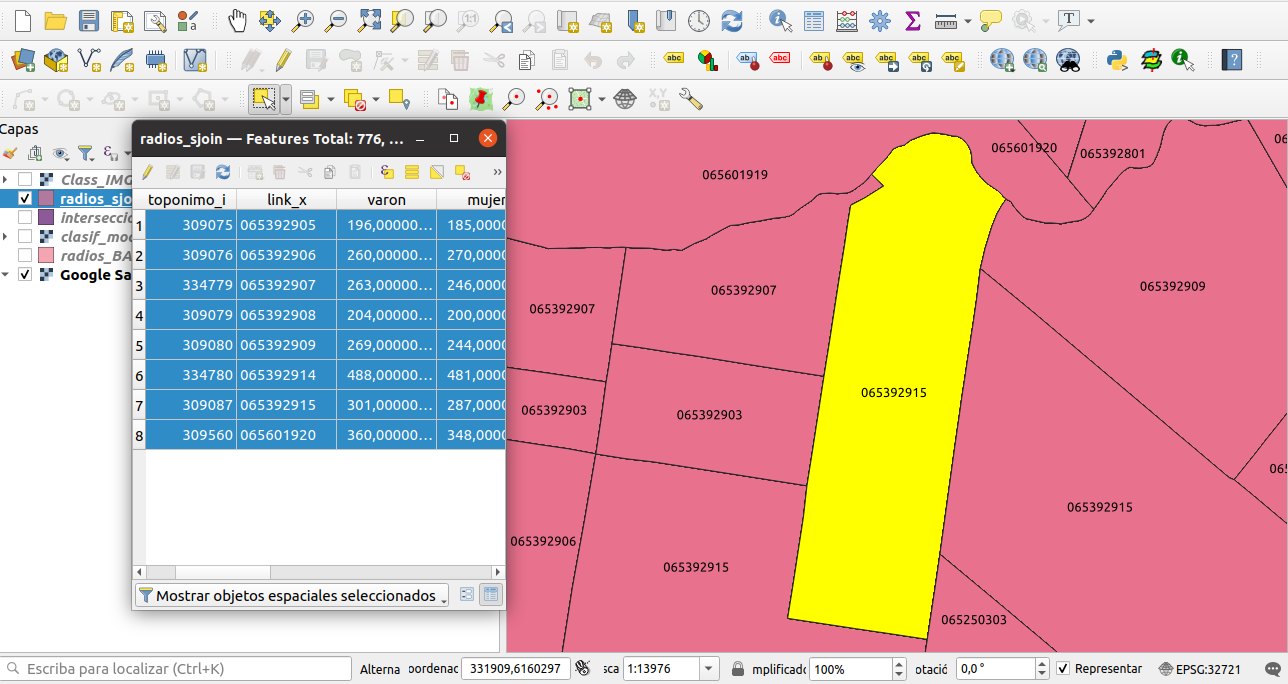

Claramente esto no es lo que buscamos: Seleccionamos una geometría en QGIS y resulta que se mezcló con los elementos vecinos,  y también con los vecinos de sus vecinos!

Ese tipo de problemas no aparecería si el join espacial se hiciera entre puntos y polígonos. Lo que podemos hacer es convertir el GeoDataframe **interseccion_clasif_radios_dissolve** a una capa de puntos, y luego probar el join espacial contra **radios** (polígono).

Así como con el método **boundary** obtenemos los límites o bordes de un polígono, con el método **centroid** podemos generar el centroide del mismo. En SIG el centroide representa el punto central o medio de una geometría:

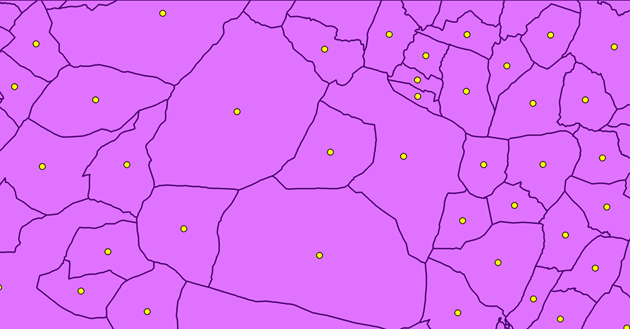



```python
centroides = dissolve.copy()

#Pasamos la geometría a punto usando Centroid
centroides.geometry=centroides.geometry.centroid

#Corroboramos que tenga todos los datos:
centroides.head()
```

In [33]:
centroides = dissolve.copy()

#Pasamos la geometría a punto usando Centroid
centroides.geometry=centroides.geometry.centroid

#Corroboramos que tenga todos los datos:
centroides.head()

link                        geometry  area_construido_m2  \
0  063640413  POINT (325980.636 6162846.984)        9.000000e+03   
1  063640414  POINT (326130.231 6160482.105)        7.481055e+05   
2  065250202  POINT (325261.525 6154922.631)        2.836274e+05   
3  065250301  POINT (328625.932 6156419.604)        4.747981e+06   
4  065250302  POINT (330706.464 6154012.889)        0.000000e+00   

   porcen_construido  
0           0.209782  
1           5.426627  
2           6.182404  
3          13.946572  
4           0.000000

```python
from matplotlib import pyplot as plt
ax = dissolve.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
centroides.plot(ax=ax, color = 'yellow',  zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()
```

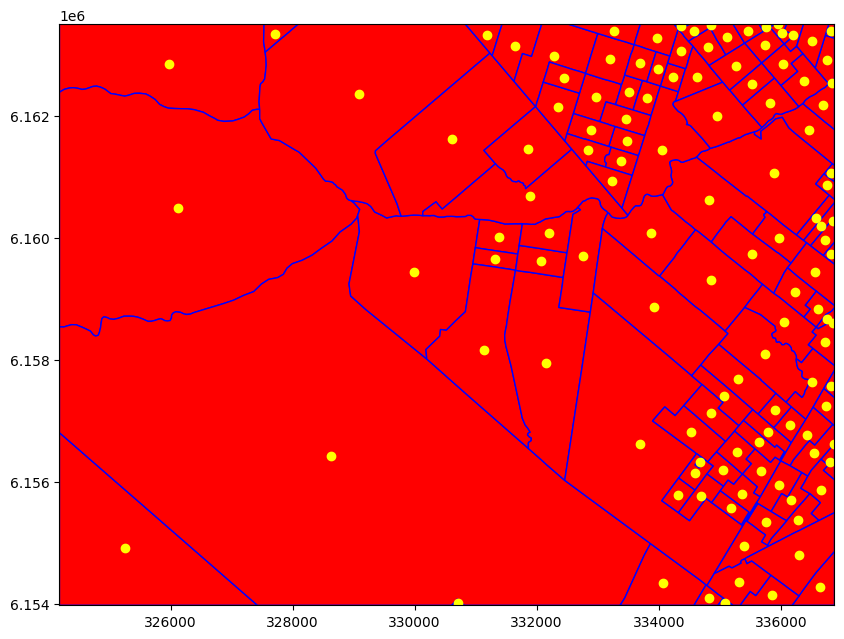

In [34]:
from matplotlib import pyplot as plt
ax = dissolve.plot(figsize=(10,10), color = 'red',edgecolor = 'blue', zorder =1)
centroides.plot(ax=ax, color = 'yellow',  zorder =2)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()

Hacemos de nuevo el Join Espacial con el predicado "contains":
Atención al orden en que pusimos esta vez a las capas!

```python
radios_sjoin = sjoin(radios,centroides, how = 'inner', predicate = 'contains')
radios_sjoin.head(3)

print(len(dissolve))
print(len(radios_sjoin))

radios_sjoin.head(3)
```

In [35]:
radios_sjoin = sjoin(radios,centroides, how = 'inner', predicate = 'contains')
radios_sjoin.head(3)

print(len(dissolve))
print(len(radios_sjoin))

radios_sjoin.head(3)

124
124


toponimo_i  link_left  varon  mujer  totalpobl  hogares  viviendasp  \
42       334684  065250303  988.0  966.0     1954.0    449.0       423.0   
633      309551  065601919  381.0  318.0      699.0    182.0       225.0   
634      309552  065602104  372.0  379.0      751.0    199.0       259.0   

     viv_part_h                                           geometry  \
42        390.0  POLYGON ((334776.418 6154315.417, 334412.718 6...   
633       179.0  POLYGON ((331984.086 6162151.557, 332043.253 6...   
634       194.0  POLYGON ((330751.758 6164418.432, 330719.756 6...   

       area_total  index_right link_right  area_construido_m2  \
42   2.296415e+06            5  065250303       263684.823441   
633  9.878810e+05           79  065601919       356944.577423   
634  7.631214e+05           95  065602104        93357.498236   

     porcen_construido  
42           31.759880  
633          36.132347  
634          60.829978

¡Ahora sí! Las dos capas tienen la misma cantidad de elementos. No parece haberse generado ninguna repetición. Para corroborarlo, guardamos la capa y la abrimos en QGIS:

```python
radios_sjoin.to_file('../data/proc/radios_sjoin_2.shp')
```

In [36]:
radios_sjoin.to_file('./proc/radios_sjoin_2.shp')

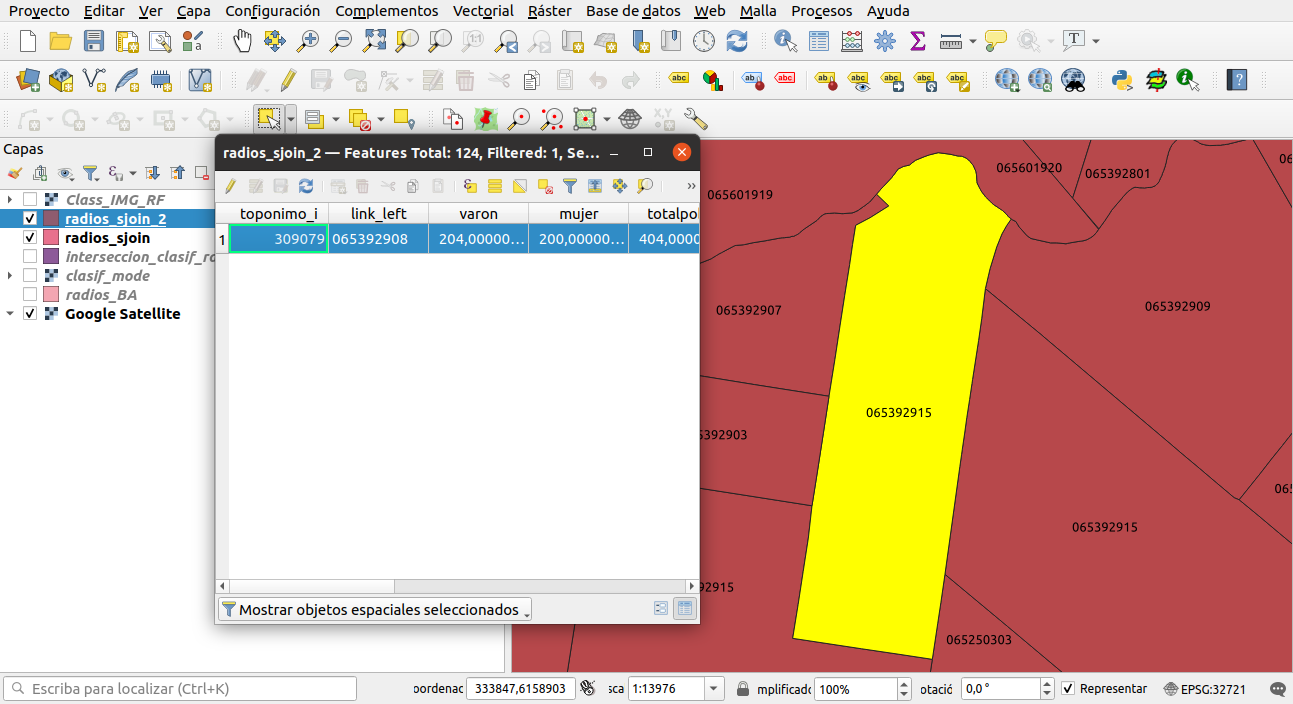

### Ejercicio 1.2:

Utilizar la información contenida en el campo 'link' de la capa de radios para generar a partir de su agregación espacial una capa de fracciones censales (tip: vas a tener que manipular la cadena de texto con los métodos aprendidos en la Clase 01, y luego usar el geoproceso Dissolve). Recordar cómo está organizada la información en esta columna: Los primeros 2 caracteres se refieren al código de provincia, los siguientes 3 al código de partido o departamento, los siguientes 2 al código de fracción, y los últimos 2 al código de radio.

### Ejercicio 1.3:

b) Usar un join espacial para pasarle a la capa puntual de establecimientos educativos (**../data/raw_data/vector/establecimientos_educativos.gpkg**) el dato de la fracción censal a la que pertenecen. Tener en cuenta que las capas pueden estar en un Sistema de Referncia distinto, y habrá que reproyectarlas previamente.

In [37]:
#Ejercicio 1.2

import geopandas as gpd

radios = gpd.read_file('./raw_data/vector/radios_BA.shp')

radios['cod_frac'] = radios['link'].str[:7]

fracciones = radios.dissolve(by='cod_frac')

fracciones = fracciones.reset_index()

fracciones.to_file('./proc/fracciones_censales.shp')

<Axes: >

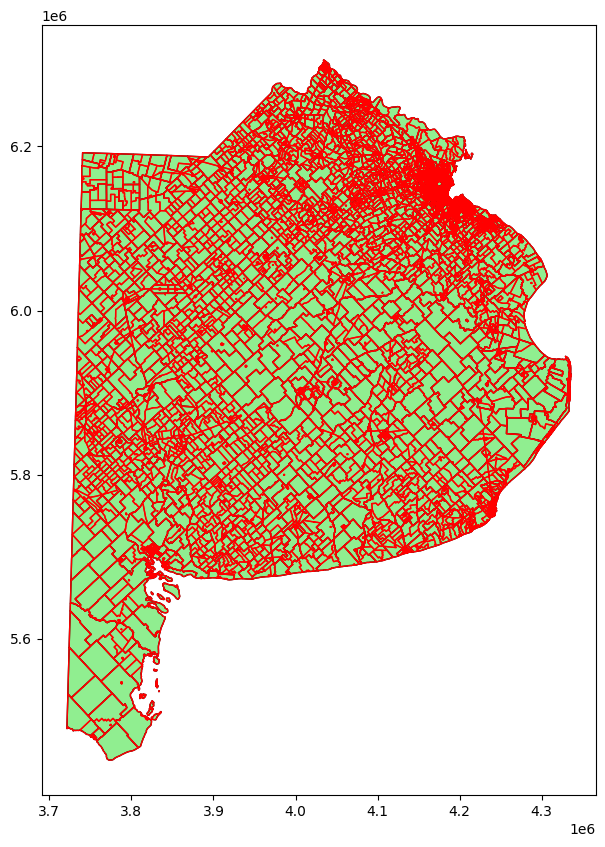

In [38]:
ax = fracciones.plot(figsize=(10, 10), edgecolor='black', facecolor='lightgreen')
radios.plot(ax=ax, edgecolor='red', facecolor='none')

In [42]:
import geopandas as gpd

fracciones = gpd.read_file('./proc/fracciones_censales.shp')

educativos = gpd.read_file('./raw_data/vector/establecimientos_educativos.gpkg')

print("CRS fracciones:", fracciones.crs)
print("CRS educativos:", educativos.crs)

if educativos.crs != fracciones.crs:
    educativos = educativos.to_crs(fracciones.crs)

educativos_con_fraccion = gpd.sjoin(educativos, fracciones[['cod_frac', 'geometry']], how='left', predicate='within')


educativos_con_fraccion.to_file('./proc/educativos_con_fraccion.shp')


print(educativos_con_fraccion[['fna', 'cod_frac']].head())

CRS fracciones: EPSG:22183
CRS educativos: EPSG:4326
                                               fna cod_frac
0                                   Escuela Nº 282      NaN
1                                             EPAC  0644109
2                                    Escuela N° 72      NaN
3                        Escuela N° 4518 Ex N° 730      NaN
4  Escuela Nº 4350 Nuestra Señora de la Candelaria      NaN


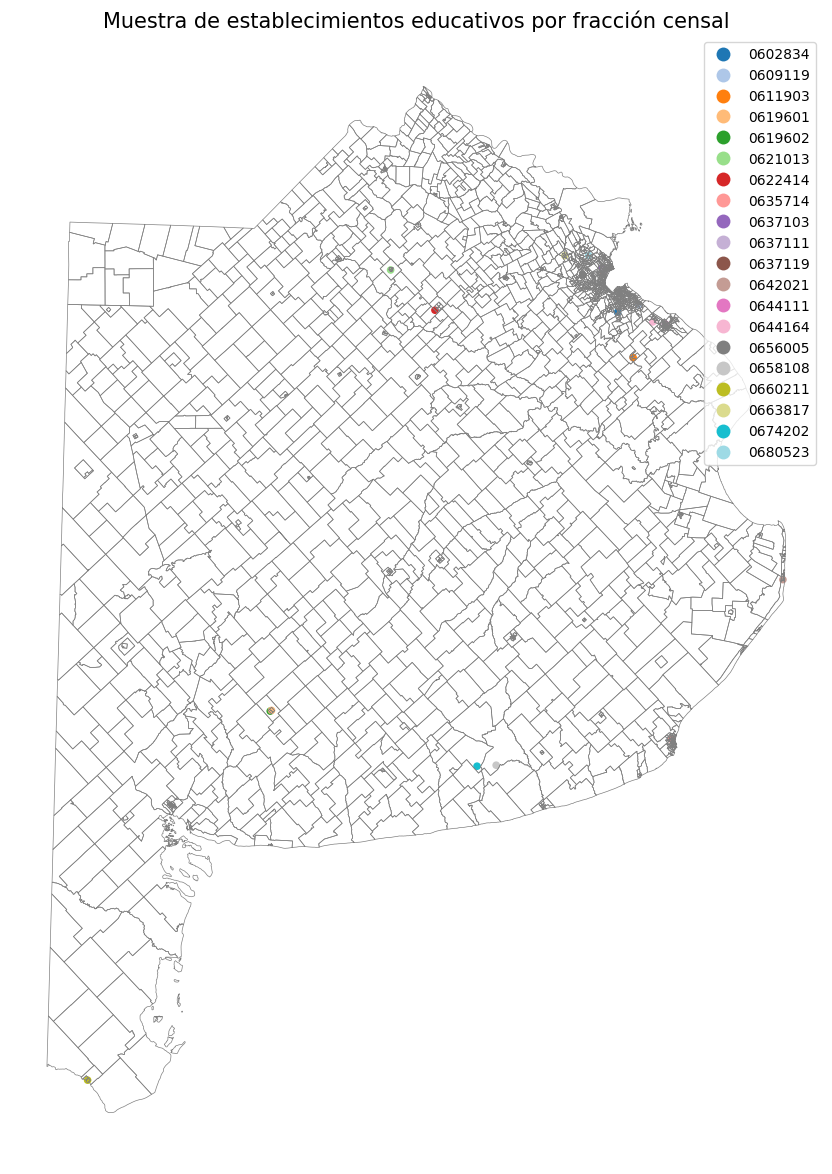

In [43]:
educativos_sample = educativos_con_fraccion.sample(n=50, random_state=42)

plt.figure(figsize=(12, 12))

fracciones.boundary.plot(ax=plt.gca(), edgecolor='gray', linewidth=0.5)

educativos_sample.plot(ax=plt.gca(), column='cod_frac', cmap='tab20', markersize=20, legend=True)

plt.title("Muestra de establecimientos educativos por fracción censal", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()